In [12]:
import pandas as pd
import numpy as np
import PI_client as pc
import matplotlib
import sklearn as sk

In [13]:
client = pc.pi_client() # Open client to data historian 

In [14]:
#l, d = client.search_by_point("*shields*") 

In [15]:
l, d = client.search_by_point("*AP*Total*") # Finding data point name for WiFi connections - targeting Student Community Center (SCC). This is because we know there is a security sweep that forces everyone out of the building at 11pm (gives ground truth) 

In [16]:
l, d = client.search_by_point("*co2*") # Getting another vacancy-related data point, carbon dioxide levels. Use all of them? What else do we have?
#l

In [17]:
points = ["AP.STUD-COMM-CTR_Total_Count", 'SCC.AHU.AHU01.MAXCO2', 'SCC.AHU.AHU01.RM.1002.CO2', 'SCC.AHU.AHU01.RM.1003.CO2', 'SCC.AHU.AHU01.RM.1101.1.CO2', 'SCC.AHU.AHU01.RM.1101.2.CO2', 'SCC.AHU.AHU01.RM.1101A.CO2', 'SCC.AHU.AHU01.RM.1110.CO2', 'SCC.AHU.AHU01.RM.1200.CO2', 'SCC.AHU.AHU01.RM.1303.CO2', 'SCC.AHU.AHU01.RM.1306.CO2', 'SCC.AHU.AHU01.RM.1402.CO2', 'SCC.AHU.AHU01.RM.1402A.CO2', 'SCC.AHU.AHU01.RM.2002.CO2', 'SCC.AHU.AHU01.RM.2003.CO2', 'SCC.AHU.AHU01.RM.2004.CO2', 'SCC.AHU.AHU01.RM.2101.1.CO2', 'SCC.AHU.AHU01.RM.2101.2.CO2', 'SCC.AHU.AHU01.RM.2102.CO2', 'SCC.AHU.AHU01.RM.2103.CO2', 'SCC.AHU.AHU01.RM.2201.CO2', 'SCC.AHU.AHU01.RM.2204.CO2', 'SCC.AHU.AHU01.RM.2303.CO2', 'SCC.AHU.AHU01.RM.2401.CO2',"SMOA.AHU.AHU01.Outside Air CO2 PPM"]
#points = ["AP.STUD-COMM-CTR_Total_Count", 'SCC.AHU.AHU01.MAXCO2', 'SMOA.AHU.AHU01.Outside Air CO2 PPM']
data = client.get_stream_by_point(points,start="2018-08-01") # Getting the data into a dataframe *note* this will pull interpolated data, raw can be specified.
#data.head()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [18]:
#data.plot(figsize=(18,5))

In [19]:
#data.head()

In [20]:
#data["vacant"] = np.where(((data.index.hour > 23) | (data.index.hour < 7 )) | (data.index.dayofweek > 4), 1000, 0) # blowing up the y-scale for visualization purposes
data["vacant"] = np.where(((data.index.hour > 23) | (data.index.hour < 7 )) | (data.index.dayofweek > 4), 1, 0) # vacant between 11pm and 7am on saturday and sunday (this analysis was performed for Summer data - this "vacancy window" needs to be modified to match the information at https://cru.ucdavis.edu/content/336-hours-location-amp-contact.htm)

In [21]:
# Find first window of missing data:
#data.loc["2018-08-15 00:00:00":"2018-08-22 09:00:00",:].plot(figsize=(18,5))

In [22]:
# Find second window of missing data:
#data.loc["2018-09-14 02:00:01":"2018-09-15 23:59:59",:].plot(figsize=(18,5))

In [33]:
span = [(data.index < "2018-08-15 00:00:00") | (data.index > "2018-08-22 09:00:00"), (data.index < "2018-09-14 02:00:01") | (data.index > "2018-09-15 23:59:59")]
mask = pd.Series([True]*len(data.index), index = data.index)

for i in span:
    mask &= i

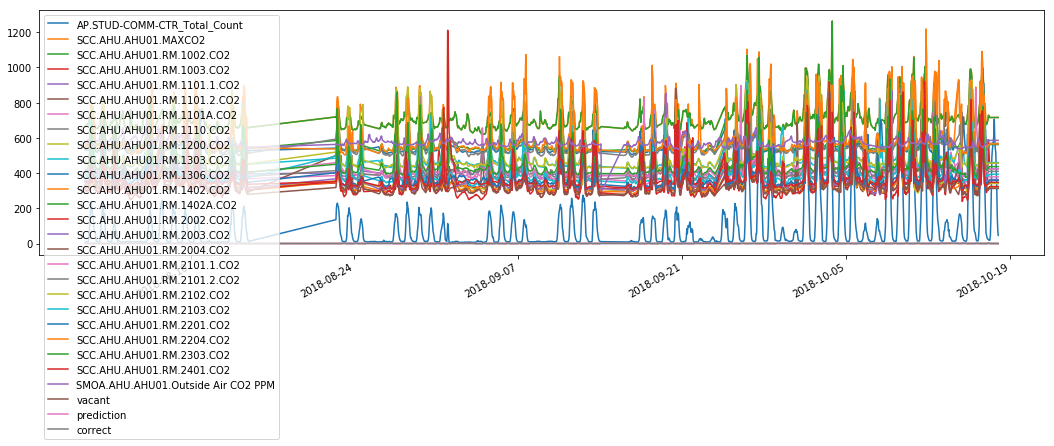

In [34]:
data.loc[mask,:].plot(figsize=(18,5)) # apply vacancy mask to data and plot it

In [35]:
from sklearn import linear_model
mod = linear_model.LogisticRegression()

In [36]:
model = mod.fit(data[points], data["vacant"])
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

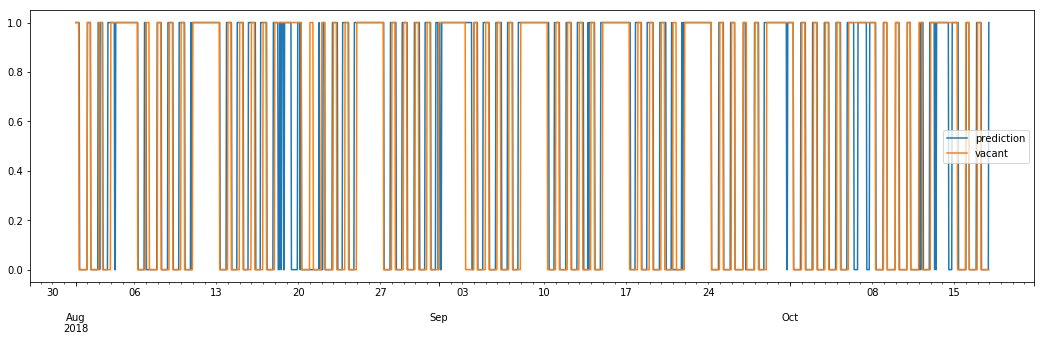

In [37]:
data["prediction"] = model.predict(data[points])
#data["prediction"] = 0
data[["prediction","vacant" ]].plot(figsize=(18,5))

In [38]:
i = sum(data["prediction"])

In [40]:
data['correct'] = (data['prediction'] - data['vacant']) == 0
errors = len(data['vacant']) - data['correct'].sum() # number of observations - number correct = number of errors
precision = 1 - errors/len(data['vacant'])
precision

0.8381410256410257